In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

In [14]:
test_df = pd.read_csv('test.csv', encoding = 'utf-8')
train_df = pd.read_csv('train.csv', encoding = 'utf-8')

# '[.]'을 '.'으로 복구
train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

In [16]:
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

In [17]:
# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

In [18]:
# 특수 문자('-', '_', '/') 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))

In [19]:
train_df

,ID,URL,label,length,subdomain_count,special_char_count
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,3
...,...,...,...,...,...,...
6995051,TRAIN_6995051,ddht.co.kr,0,10,1,0
6995052,TRAIN_6995052,www.upstartepoxy.com,0,20,1,0
6995053,TRAIN_6995053,employeesalaryschedule70.000webhostapp.com/adb...,1,50,1,2
6995054,TRAIN_6995054,dekalbtool.com,0,14,0,0


In [20]:
test_df

,ID,URL,length,subdomain_count,special_char_count
0,TEST_0000000,niquelarte.blogspot.com.es,26,2,0
1,TEST_0000001,northernmetalproducts.com,25,0,0
2,TEST_0000002,ga.de,5,0,0
3,TEST_0000003,florawww.eeb.uconn.edu/199300089.html,37,3,1
4,TEST_0000004,activecity.moscow,17,0,0
...,...,...,...,...,...
1747684,TEST_1747684,culliganlaredo.com,18,0,0
1747685,TEST_1747685,tenzidetailer.pl,16,0,0
1747686,TEST_1747686,club-hippique-neubourg.fr,25,0,2
1747687,TEST_1747687,smbcyt.com/,11,0,1


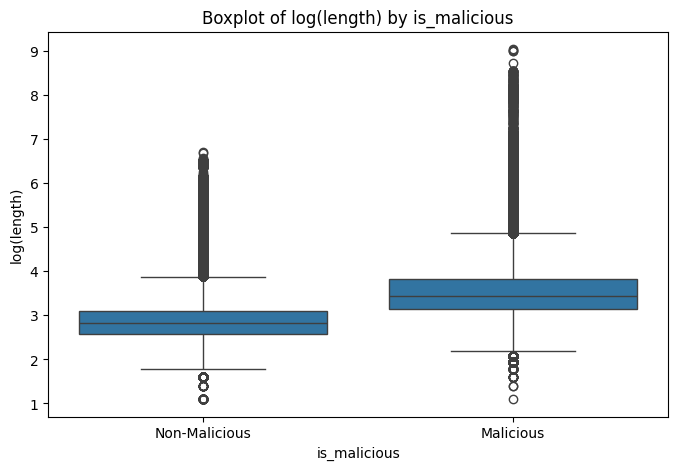

C:\venvs\py310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


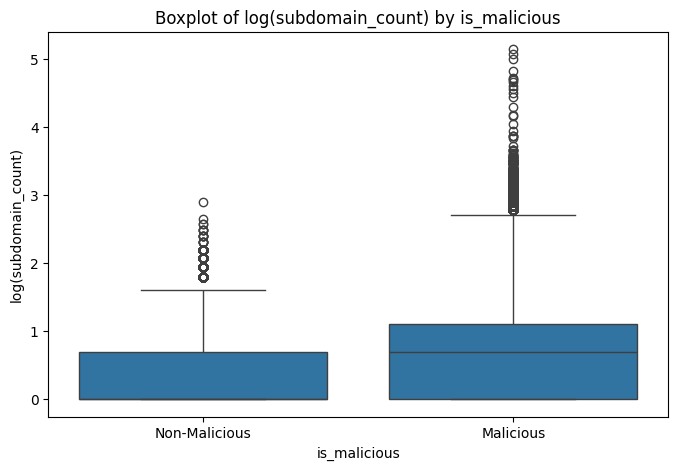

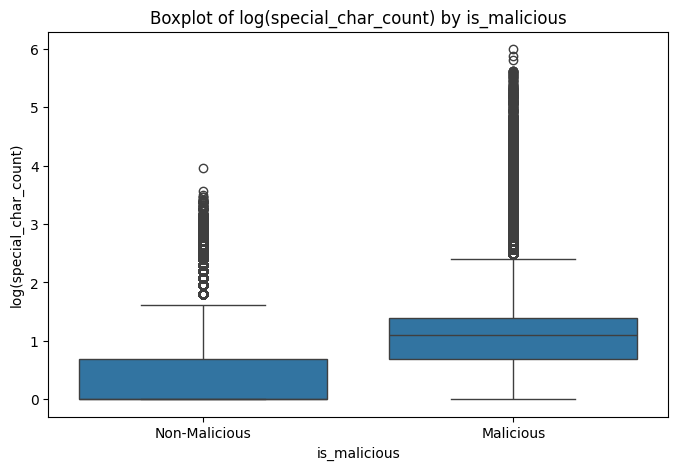

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

variables = ['length', 'subdomain_count', 'special_char_count']

for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=np.log1p(train_df[var]))  # log(1+x)
    plt.title(f"Boxplot of log({var}) by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(f"log({var})")
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()


In [25]:
# label과의 상관관계 확인
#피어슨 상관계수(Pearson correlation) 구하기
corr = train_df[['length', 'subdomain_count', 'special_char_count', 'label']].corr()
print(corr['label'].sort_values(ascending=False))

#결과 값을 보아 양의 상관관계를 가지나 엄청 큰 상관관계라 보긴 어렵다.

label                 1.000000
special_char_count    0.356997
subdomain_count       0.350023
length                0.326656
Name: label, dtype: float64


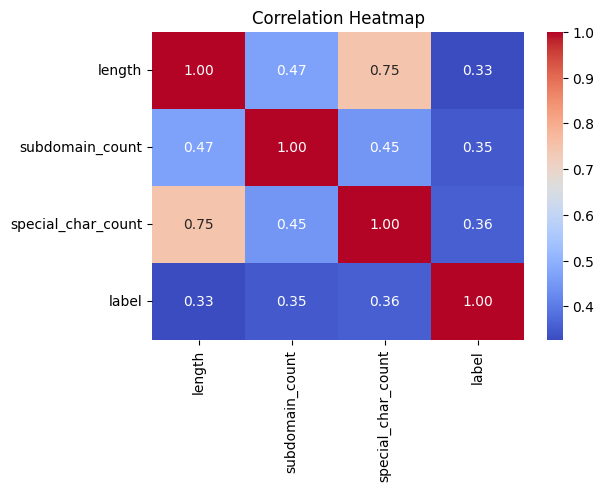

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#label과의 상관관계를 보면 마찬가지로 큰 상관관계는 없었음.
#새로운 피처가 필요


In [34]:
#숫자 개수
train_df["num_digits"] = train_df["URL"].apply(lambda x: sum(c.isdigit() for c in x))
test_df["num_digits"] = test_df["URL"].apply(lambda x: sum(c.isdigit() for c in x))

In [38]:
#대문자 포함 여부
train_df["upper_case"] = train_df["URL"].apply(
    lambda x: 0 if pd.isna(x) else (1 if any(c.isupper() for c in str(x)) else 0)
)

test_df["upper_case"] = test_df["URL"].apply(
    lambda x: 0 if pd.isna(x) else(1 if any(c.isupper() for c in str(x)) else 0)
)

In [40]:
#URL 깊이
train_df["depth"] = train_df["URL"].apply(
    lambda x: len(x.strip("/").split("/")) - 1 if len(x.strip("/").split("/")) > 1 else 0
)
#URL 깊이
test_df["depth"] = test_df["URL"].apply(
    lambda x: len(x.strip("/").split("/")) - 1 if len(x.strip("/").split("/")) > 1 else 0
)

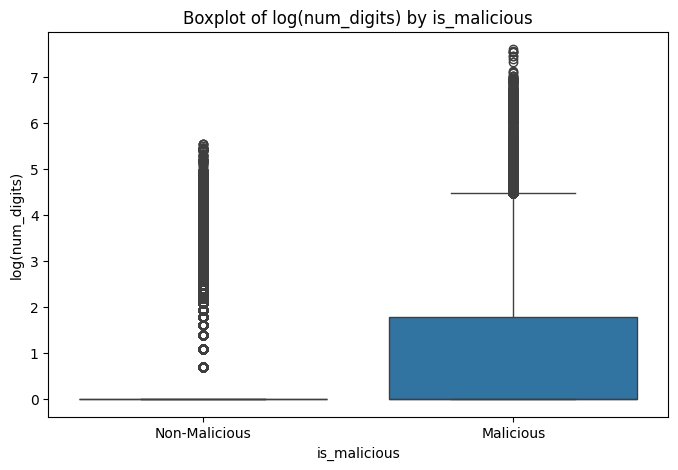

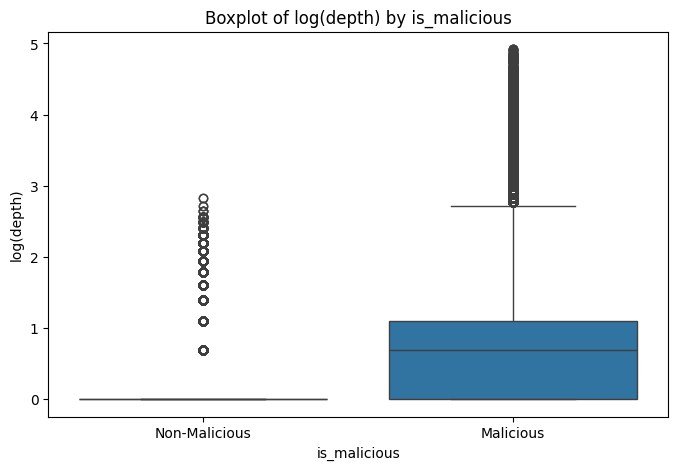

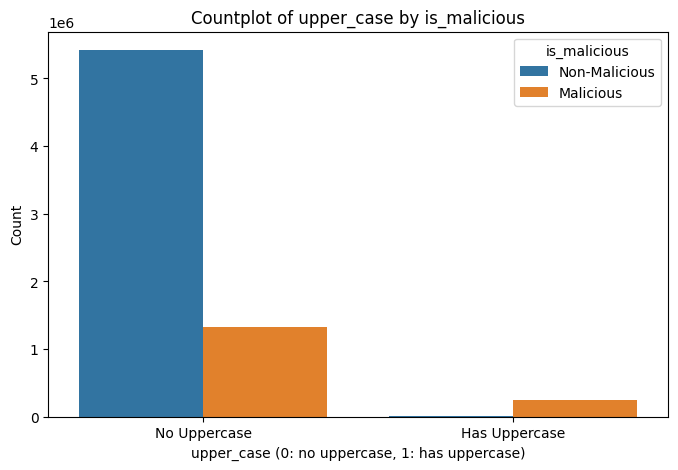

In [45]:
variables = ['num_digits', 'depth']  # 연속형 변수

for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=np.log1p(train_df[var]))  # log(1+x)
    plt.title(f"Boxplot of log({var}) by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(f"log({var})")
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

# upper_case는 이진 변수이므로 countplot으로
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='upper_case', hue='label')
plt.title("Countplot of upper_case by is_malicious")
plt.xlabel("upper_case (0: no uppercase, 1: has uppercase)")
plt.ylabel("Count")
plt.xticks([0, 1], ['No Uppercase', 'Has Uppercase'])
plt.legend(title='is_malicious', labels=['Non-Malicious', 'Malicious'])
plt.show()


In [54]:
# label과의 상관관계 확인
#피어슨 상관계수(Pearson correlation) 구하기
corr = train_df[['num_digits', 'depth', 'upper_case', 'label']].corr()
print(corr['label'].sort_values(ascending=False))


label         1.000000
upper_case    0.343132
depth         0.306066
num_digits    0.251723
Name: label, dtype: float64


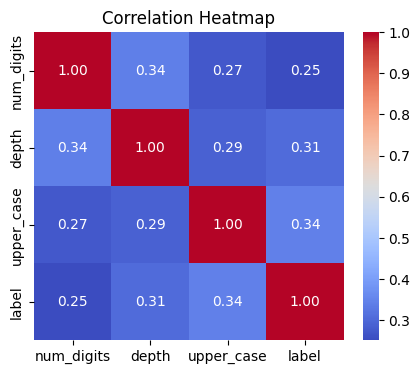

In [55]:
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#양의 상관관계인 것은 맞으나, 큰 의미는 없어보임

In [57]:
# URL 무작위성
def calculate_entropy(url):
    # 문자 빈도수 계산
    counter = Counter(url)
    length = len(url)

    # 섀넌 엔트로피 계산
    entropy = 0
    for count in counter.values():
        probability = count / length
        entropy -= probability * math.log2(probability)
    return entropy

def check_randomness(url):
    # 1. 엔트로피 계산
    entropy = calculate_entropy(url)

    # 2. 연속된 숫자나 문자의 최대 길이
    max_consecutive = 1
    current_consecutive = 1
    for i in range(1, len(url)):
        if (
            url[i].isalnum()
            and url[i - 1].isalnum()
            and url[i].lower() == url[i - 1].lower()
        ):
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 1

    # 3. 숫자와 문자의 교차 패턴 수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i - 1].isdigit() and url[i].isalpha()) or (
            url[i - 1].isalpha() and url[i].isdigit()
        ):
            transitions += 1

    # 무작위성 점수 계산 (0~1 사이로 정규화)
    entropy_score = min(entropy / 5.0, 1.0)  # 일반적인 URL의 최대 엔트로피를 5로 가정
    consecutive_score = min(
        max_consecutive / 10.0, 1.0
    )  # 연속된 문자가 많을수록 낮은 점수
    transition_score = min(transitions / 10.0, 1.0)  # 전환이 많을수록 높은 점수

    # 종합 점수 계산 (가중치 조정 가능)
    randomness_score = (
        entropy_score * 0.5 + (1 - consecutive_score) * 0.3 + transition_score * 0.2
    )

    return randomness_score

NameError: name 'Counter' is not defined

In [58]:
# URL 무작위성
train_df["randomness"] = train_df["URL"].apply(check_randomness)
test_df["randomness"] = test_df["URL"].apply(check_randomness)

NameError: name 'Counter' is not defined